## Dependencias

In [ ]:
!pip install pandas
!pip install scipy

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import models,layers,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
ruta  = '/tf/bd/cats_dogs_mini/'

## Red profunda desde donde se transferirá el conocimiento

In [3]:
base = VGG16(weights='imagenet', #Características aprendidas
             include_top=False, #Descartar capa densa final
             input_shape=(150,150,3))

In [4]:
base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Creación de conjuntos de datos

In [5]:
dest = '/tf/bd/cats_dogs_mini/'

In [6]:
train = ImageDataGenerator(rotation_range=40, #Rota las imágenes aleatoriamente
                           width_shift_range=0.2, # Traslada horizontalmente
                           height_shift_range=0.2, #Traslada verticalmente
                           shear_range=0.2, #transformaciones de corte (cizalla)
                           zoom_range=0.2, #acercamientos aleatorios
                           horizontal_flip=True, #Voltea horizontalmente
                           fill_mode='nearest',
                           rescale = 1/255
                          )


test = ImageDataGenerator(rescale=1/255)

In [7]:
train = train.flow_from_directory(os.path.join(dest,'train'),
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 2000 images belonging to 2 classes.


In [8]:
validation = test.flow_from_directory(os.path.join(dest,'validate'),
                                  target_size=(150,150),
                                  batch_size=20,
                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


## Acoplamiento de capa final para adaptar al clasificador binario

In [9]:
modelo = models.Sequential()
modelo.add(base)
modelo.add(layers.Flatten())
modelo.add(layers.Dropout(0.5))
modelo.add(layers.Dense(512,activation='relu'))
modelo.add(layers.Dense(1,activation='sigmoid'))
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


In [10]:
base.trainable = False

In [11]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
modelo.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=1e-4),
               metrics=['acc'])
history = modelo.fit_generator(train,
                     steps_per_epoch=2000//32,
                     epochs=30,
                     validation_data=validation,
                     validation_steps=50)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
62/62 [==============================] - 22s 274ms/step - loss: 0.6085 - acc: 0.6885 - val_loss: 0.3535 - val_acc: 0.8590
Epoch 2/30
62/62 [==============================] - 14s 222ms/step - loss: 0.4739 - acc: 0.7820 - val_loss: 0.3170 - val_acc: 0.8650
Epoch 3/30
62/62 [==============================] - 13s 215ms/step - loss: 0.4448 - acc: 0.7891 - val_loss: 0.2908 - val_acc: 0.8770
Epoch 4/30
62/62 [==============================] - 14s 217ms/step - loss: 0.4256 - acc: 0.8054 - val_loss: 0.2857 - val_acc: 0.8770
Epoch 5/30
62/62 [==============================] - 14s 230ms/step - loss: 0.3971 - acc: 0.8211 - val_loss: 0.3469 - val_acc: 0.8540
Epoch 6/30
62/62 [==============================] - 13s 215ms/step - loss: 0.4127 - acc: 0.8100 - val_loss: 0.3457 - val_acc: 0.8380
Epoch 7/30
62/62 [==============================] - 13s 215ms/step - loss: 0.3963 - acc: 0.8120 - val_loss: 0.2870 - val_acc: 0.8740
Epoch 8/30
62/62 [==============================] - 16s 259ms/step - 

## Resultados

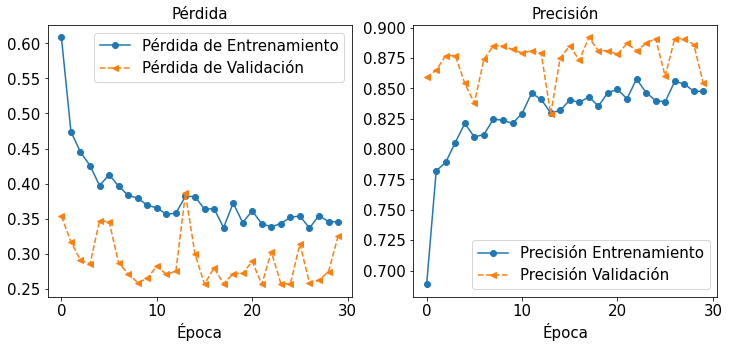

In [13]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['acc'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_acc'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

In [15]:
modelo.save('gatos_perros_transfer_vgg16.h5')